<a href="https://colab.research.google.com/github/harikiran-mudipalli/Detectron2/blob/master/detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

!pip install awscli 

import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Requirement already up-to-date: torch==1.4+cu100 in /usr/local/lib/python3.6/dist-packages (1.4.0+cu100)
Requirement already up-to-date: torchvision==0.5+cu100 in /usr/local/lib/python3.6/dist-packages (0.5.0+cu100)
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6nzqbb6k
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6nzqbb6k
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266458 sha256=8c252b7efe445a6995e54fab278bbe3ad19362da9cc8de58884c30af167b5c36
  Stored in directory: /tmp/pip-ephem-wheel-cache-9xobymkm/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software F

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.7MB 447kB/s 
     |████████████████████████████████| 2.2MB 4.8MB/s 
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp36-cp36m-linux_x86_64.whl size=266524 sha256=c2a2900c71a83ed1fcccd655fd0783b1d7f01910c18b299763e01be57938a4ca
  Stored in directory: /root/.cache/pip/wheels/68/a5/e7/56401832f23d0b2db351c5b682e466cb4841960b086da65e4e
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200716-cp36-none-any.whl size=42325 sha256=54320d3531f2e8abd62e127b244f0c96bc9780f1ab21667d6ad3eaeb0fb97035
  Stored in directory: /root/.cache/pip/wheels/81/99/f4/42a6bef61c07b3d78dfe6d7ebff259444c4526504cf72378d7
Successfully built pycocotools fvcore
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully

In [3]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
img = cv2.imread("./drive/My Drive/person.jpeg")
#cv2_imshow(img)

In [5]:
# Download the trained model
!wget https://storage.googleapis.com/airbnb-amenity-detection-storage/airbnb-amenity-detection/open-images-data/retinanet_model_final/retinanet_model_final.pth

# Download the train model config (instructions on how the model was built)
!wget https://storage.googleapis.com/airbnb-amenity-detection-storage/airbnb-amenity-detection/open-images-data/retinanet_model_final/retinanet_model_final_config.yaml

--2020-09-04 06:55:22--  https://storage.googleapis.com/airbnb-amenity-detection-storage/airbnb-amenity-detection/open-images-data/retinanet_model_final/retinanet_model_final.pth
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 74.125.141.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.204.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 446656531 (426M) [application/octet-stream]
Saving to: ‘retinanet_model_final.pth’

retinanet_model_fin 100%[===================>] 425.96M  85.7MB/s    in 5.1s    

2020-09-04 06:55:28 (83.7 MB/s) - ‘retinanet_model_final.pth’ saved [446656531/446656531]

--2020-09-04 06:55:28--  https://storage.googleapis.com/airbnb-amenity-detection-storage/airbnb-amenity-detection/open-images-data/retinanet_model_final/retinanet_model_final_config.yaml
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.204.128, 172.217.203.128, 74.125.141.128, 

In [7]:
target_classes = ['Bathtub',
 'Bed',
 'Billiard table',
 'Ceiling fan',
 'Coffeemaker',
 'Couch',
 'Countertop',
 'Dishwasher',
 'Fireplace',
 'Fountain',
 'Gas stove',
 'Jacuzzi',
 'Kitchen & dining room table',
 'Microwave oven',
 'Mirror',
 'Oven',
 'Pillow',
 'Porch',
 'Refrigerator',
 'Shower',
 'Sink',
 'Sofa bed',
 'Stairs',
 'Swimming pool',
 'Television',
 'Toilet',
 'Towel',
 'Tree house',
 'Washing machine',
 'Wine rack',
 'Person']

class_dict = {'0':'Bathtub',
 '1':'Bed',
 '2':'Billiard table',
 '3':'Ceiling fan',
 '4':'Coffeemaker',
 '5':'Couch',
 '6':'Countertop',
 '7':'Dishwasher',
 '8':'Fireplace',
 '9':'Fountain',
 '10':'Gas stove',
 '11':'Jacuzzi',
 '12':'Kitchen & dining room table',
 '13':'Microwave oven',
 '14':'Mirror',
 '15':'Oven',
 '16':'Pillow',
 '17':'Porch',
 '18':'Refrigerator',
 '19':'Shower',
 '20':'Sink',
 '21':'Sofa bed',
 '22':'Stairs',
 '23':'Swimming pool',
 '24':'Television',
 '25':'Toilet',
 '26':'Towel',
 '27':'Tree house',
 '28':'Washing machine',
 '29':'Wine rack',
 '30':'Person'}

In [8]:
def preds(img, show=False):
  img = cv2.imread("./drive/My Drive/"+img)

  cfg = get_cfg()
  cfg.merge_from_file("./retinanet_model_final_config.yaml")
  cfg.MODEL.WEIGHTS = "./retinanet_model_final.pth" 
  
  predictor = DefaultPredictor(cfg)
  outputs = predictor(img)

  if show==True:
    num_amenities = 6
    visualizer = Visualizer(img_rgb=img[:, :, ::-1], 
                        metadata=MetadataCatalog.get(cfg.DATASETS.TEST[0]).set(thing_classes=target_classes), 
                        scale=0.7)
    visualizer = visualizer.draw_instance_predictions(outputs["instances"][:num_amenities].to("cpu"))
    cv2_imshow(visualizer.get_image()[:, :, ::-1])
  num_amenities = 6
  score_list = outputs["instances"][:num_amenities].to("cpu").scores.tolist() 
  class_list = outputs["instances"][:num_amenities].to("cpu").pred_classes.tolist()

  for x in range(len(class_list)):
    print(class_dict[str(class_list[x])]+' : '+str(score_list[x]))

In [9]:
def isPerson(img, show=False):
  im = cv2.imread("./drive/My Drive/"+img)

  cfg = get_cfg()
  # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
  cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
  cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
  # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
  cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
  predictor = DefaultPredictor(cfg)
  outputs = predictor(im)

  from detectron2.data import MetadataCatalog
  targets = []
  targets_dict = {}
  for i, name in enumerate(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes):
    targets.append(name)
    targets_dict[i]=name

  # We can use `Visualizer` to draw the predictions on the image.
  if show==True:
    v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).set(thing_classes=targets), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

  num_amenities = 6
  score_list = outputs["instances"][:num_amenities].to("cpu").scores.tolist()
  class_list = outputs["instances"][:num_amenities].to("cpu").pred_classes.tolist()

  c = 0; p = 0
  for x in range(len(class_list)):
    if class_list[x] == 0 and score_list[x] > 0.1:
      print("Invalid Image")
      p = 1
      break
    c += 1
  if c == len(class_list):
    print('Uploaded Successfully')
  #print(targets_dict[str(class_list[x])]+' : '+str(score_list[x]))

  return p

In [11]:
def result(img):

  if isPerson(img) == 1:
    isPerson(img, show=True)
  else:
    preds(img, show=True)

model_final_f10217.pkl: 178MB [00:09, 18.1MB/s]                           


Invalid Image


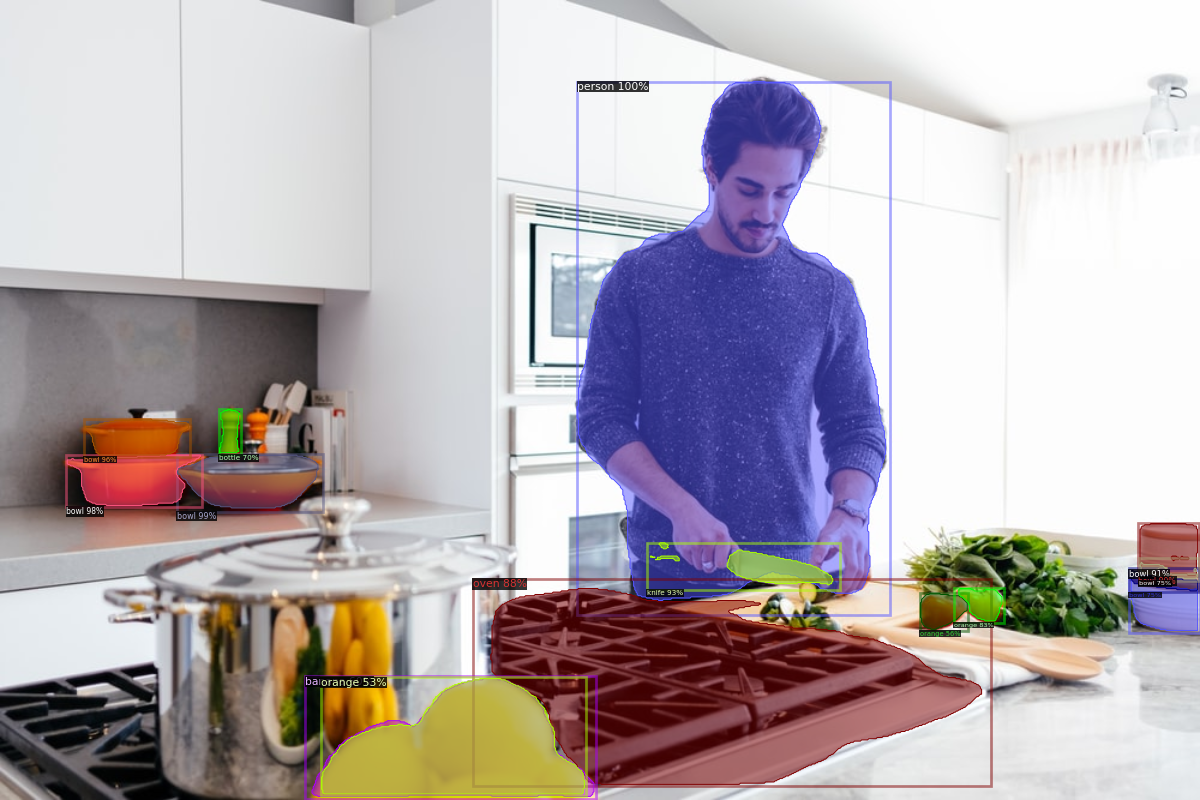

Invalid Image


In [12]:
result("person.jpeg")

Uploaded Successfully


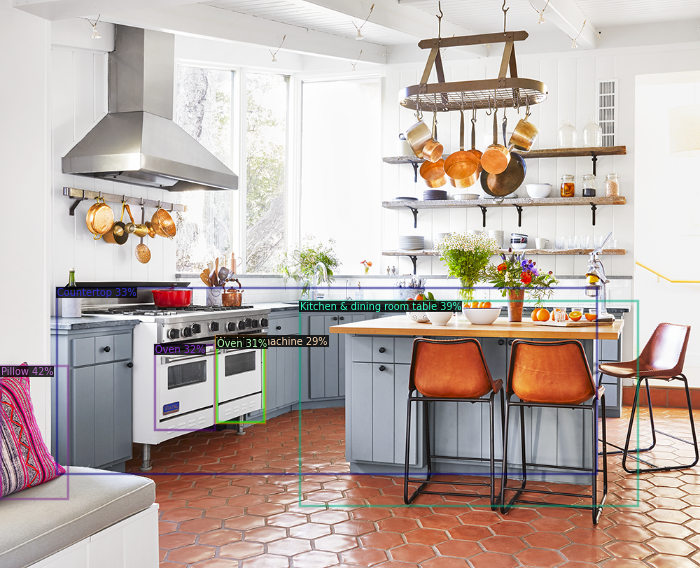

Pillow : 0.4156094193458557
Kitchen & dining room table : 0.3878413438796997
Countertop : 0.33276674151420593
Oven : 0.32473641633987427
Oven : 0.305441290140152
Washing machine : 0.29405784606933594


In [13]:
result("kitchen.png")